# Библиотеки

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plot
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve

# Чтение файла

In [2]:
data = pandas.read_csv('https://raw.githubusercontent.com/a-milenkin/datasets_for_t-tests/main/athletes.csv')
EPOCHS = 100
LEARNING_RATE = 0.2

# Функции

In [3]:
#Получаем входные данные
def GetX():
    global data
    data = data[pandas.isnull(data['weight']) == 0 ]
    selected_columns = data [['weight']] 
    X = pandas.get_dummies(selected_columns)
    return X

In [4]:
#Преобразование целевой переменной в численные значения
def TransformY():
    label_encoder = LabelEncoder()
    label_encoder.fit(data['sex'])
    label_encoder.classes_
    Y = pandas.Series(data = label_encoder.transform(data['sex']))
    return Y

In [5]:
#Вызов готовой модели, ее обучение и вывод точности
def StandartModel():
    print("Built-in algorithm:")
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model = LogisticRegression()
    X_train, X_test, Y_train, Y_test = train_test_split(GetX(), TransformY(), test_size=0.3, random_state=42)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    model.get_params()
    print("Score train: ", model.score(X_train, Y_train))
    print("Score test: ", model.score(X_test, Y_test))

In [6]:
#Функция стандартной нормализации входных данных
def NormalizeX():
    mu = 0
    sigma = 0
    X = []
    global data
    data = data[pandas.isnull(data['weight']) == 0 ]
    X_temp = numpy.array(data['weight'])
    len_X = len(X_temp)
    for i in range(len_X):
        mu += X_temp[i] / len_X
    for i in range(len_X):
        sigma += (X_temp[i] - mu)**2 / len_X
    for i in range(len_X):
        X.append((X_temp[i] - mu) / numpy.sqrt(sigma))
    return X

In [7]:
#Функция расчета ошибки
def GetLossFunction(X, Y, t0, t1):
    len_X = len(X)
    total_cost = 0
    for i in range(len_X):
        total_cost -= Y[i] * numpy.log(1 / (1 + numpy.exp(-t0 - t1 * X[i]))) + (1 - Y[i]) * numpy.log(1 - (1 / (1 + numpy.exp(-t0 - t1 * X[i]))))
    return total_cost / len_X

In [8]:
#Прозводная функции ошибки по первому параметру
def GetTheta0(X, Y, t0, t1):
    len_X = len(X)
    total_cost = 0
    for i in range(len_X):
        total_cost += 1 / (1 + numpy.exp(-t0 - t1 * X[i])) - Y[i]
    return total_cost / len_X 

In [9]:
#Прозводная функции ошибки по второму параметру
def GetTheta1(X, Y, t0, t1):
    len_X = len(X)
    total_cost = 0
    for i in range(len_X):
        total_cost += (1 / (1 + numpy.exp(-t0 - t1 * X[i])) - Y[i]) * X[i]
    return total_cost / len_X

In [10]:
#Функция для расчета значений сигмоиды
def GetPrediction(X, t0, t1):
    len_X = len(X)
    sigmoid = []
    for i in range(len_X):
        sigmoid.append(1 / (1 + numpy.exp(-t0 - t1 * X[i])))
    return sigmoid

In [11]:
#Функция расчета точности, Precision и Recall
def Accuracy(X, Y, t0, t1):
    len_X = len(X)
    sigmoid = 0
    score = 0
    precision = 0
    recall = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len_X):
        sigmoid = 1 / (1 + numpy.exp(-t0 - t1 * X[i]))
        if(sigmoid >= 0.5):
            if(Y[i] == 1):
                tp += 1
            else:
                fp += 1
        else:
            if(Y[i] == 1):
                fn += 1
            else:
                tn += 1
    score = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print("Score: ", score)
    print("Precision: ", precision)
    print("Recall: ", recall)


In [12]:
#Построение зависимости ошибки от эпох
def PlotLoss(loss_arr):
    plot.plot(loss_arr)
    plot.axis([0, EPOCHS, (numpy.amin(loss_arr)), numpy.amax(loss_arr)])
    plot.xlabel('Эпохи')
    plot.ylabel('Функция ошибки')
    plot.show()

In [13]:
#Построение ROC-кривой
def PlotROC(Y, sigmoid):
    fpr, tpr, thres = roc_curve(Y, sigmoid[:])
    plot.plot( fpr, tpr )
    plot.xlabel("False Positve Rate")
    plot.ylabel("True Positive Rate")
    plot.show()

In [14]:
#Стандартный градиентный спуск
def GradientModel():
    print("\nGradient descent mode:")
    global EPOCHS
    global LEARNING_RATE
    X = NormalizeX()
    Y = TransformY()
    theta0 = -1
    theta1 = 1
    theta0_optim = 0
    theta1_optim = 0
    loss_arr = []
    loss_func = 0
    loss_min = GetLossFunction(X, Y, theta0, theta1)
    for _ in range(EPOCHS):
        theta0 -= LEARNING_RATE * GetTheta0(X, Y, theta0, theta1)
        theta1 -= LEARNING_RATE * GetTheta1(X, Y, theta0, theta1)
        loss_func = GetLossFunction(X, Y, theta0, theta1)
        loss_arr.append(loss_func)
        if(loss_min > loss_func):
            loss_min = loss_func
            theta0_optim = theta0
            theta1_optim = theta1
    Accuracy(X, Y, theta0_optim, theta1_optim)
    PlotLoss(loss_arr)
    PlotROC(Y, GetPrediction(X, theta0_optim, theta1_optim))

In [15]:
#Метод Nesterov momentum
def NesterovMomentum():
    print("\nNesterov momentum mode:")
    global EPOCHS
    global LEARNING_RATE
    X = NormalizeX()
    Y = TransformY()
    theta0 = -1
    theta1 = 1
    theta0_optim = 0
    theta1_optim = 0
    loss_arr = []
    loss_func = 0
    momentum = 0.9
    loss_min = GetLossFunction(X, Y, theta0, theta1)
    v0 = LEARNING_RATE * GetTheta0(X, Y, theta0, theta1)
    v1 = LEARNING_RATE * GetTheta1(X, Y, theta0, theta1)
    for _ in range(EPOCHS):
        v0 = momentum * v0 - LEARNING_RATE * GetTheta0(X, Y, theta0, theta1)
        theta0 += momentum * v0 - LEARNING_RATE * GetTheta0(X, Y, theta0, theta1)
        v1 = momentum * v1 - LEARNING_RATE * GetTheta1(X, Y, theta0, theta1)
        theta1 += momentum * v1 - LEARNING_RATE * GetTheta1(X, Y, theta0, theta1)
        loss_func = GetLossFunction(X, Y, theta0, theta1)
        loss_arr.append(loss_func)
        if(loss_min > loss_func):
            loss_min = loss_func
            theta0_optim = theta0
            theta1_optim = theta1
    Accuracy(X, Y, theta0_optim, theta1_optim)
    PlotLoss(loss_arr)
    PlotROC(Y, GetPrediction(X, theta0_optim, theta1_optim))

In [16]:
#Метод RMSprop
def RMSProp():
    print("\nRMSProp mode:")
    global EPOCHS
    global LEARNING_RATE
    X = NormalizeX()
    Y = TransformY()
    theta0 = -1
    theta1 = 1
    theta0_optim = 0
    theta1_optim = 0
    v0 = 1
    v1 = 1
    loss_func = 0
    loss_arr = []
    Beta = 0.9
    E = 1E-7
    loss_min = GetLossFunction(X, Y, theta0, theta1)
    for _ in range(EPOCHS):
        v0 = Beta * v0 + (1.0 - Beta) * GetTheta0(X, Y, theta0, theta1)
        theta0 -= LEARNING_RATE * (GetTheta0(X, Y, theta0, theta1) / (numpy.exp(v0) + E))
        v1 = Beta * v1 + (1.0 - Beta) * GetTheta1(X, Y, theta0, theta1)
        theta1 -= LEARNING_RATE * (GetTheta1(X, Y, theta0, theta1) / (numpy.exp(v1) + E))
        loss_func = GetLossFunction(X, Y, theta0, theta1)
        loss_arr.append(loss_func)
        if(loss_min > loss_func):
            loss_min = loss_func
            theta0_optim = theta0
            theta1_optim = theta1
    Accuracy(X, Y, theta0_optim, theta1_optim)
    PlotLoss(loss_arr)
    PlotROC(Y, GetPrediction(X, theta0_optim, theta1_optim))

In [17]:
#Функция вызова функций :)
def Main():
    StandartModel()
    GradientModel()
    NesterovMomentum()
    RMSProp()

Built-in algorithm:
Score train:  0.7667760998030203
Score test:  0.7775735294117647

Gradient descent mode:
Score:  0.7697398657964887
Precision:  0.801467955603294
Recall:  0.7623020602758386


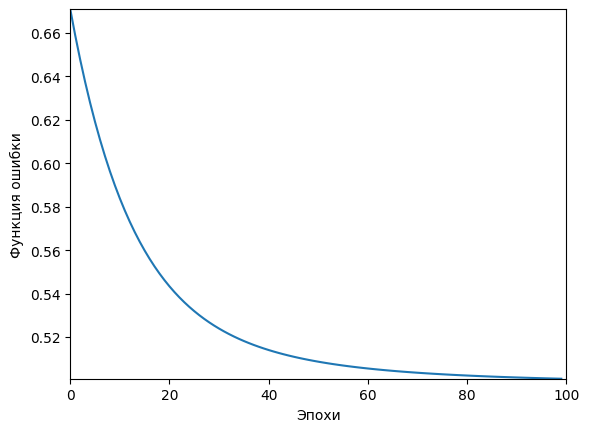

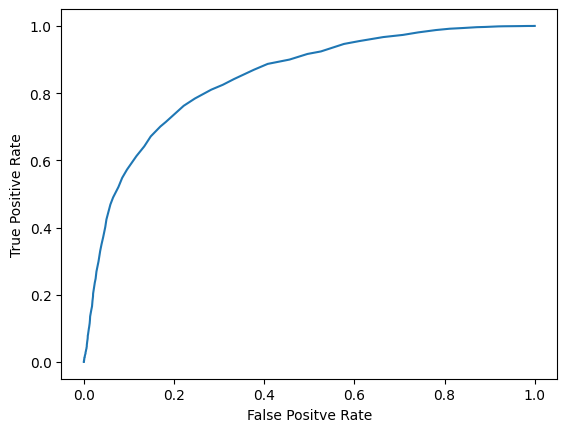


Nesterov momentum mode:
Score:  0.7700156264362533
Precision:  0.7886624421990067
Recall:  0.7840967137749021


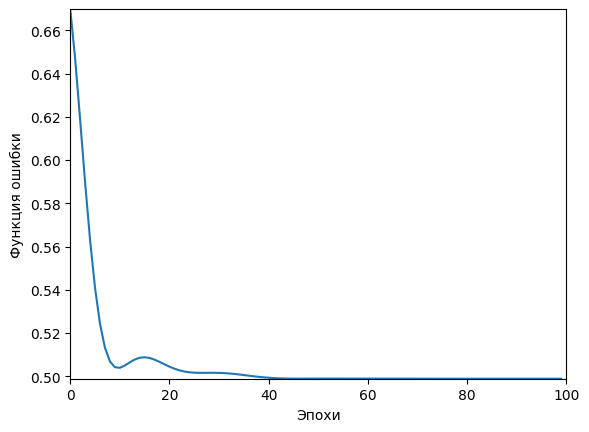

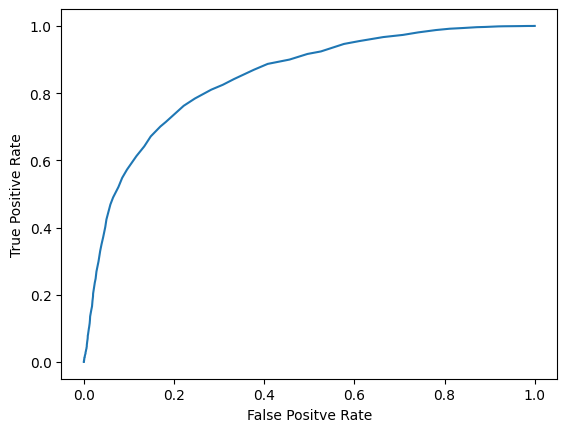


RMSProp mode:
Score:  0.7697398657964887
Precision:  0.801467955603294
Recall:  0.7623020602758386


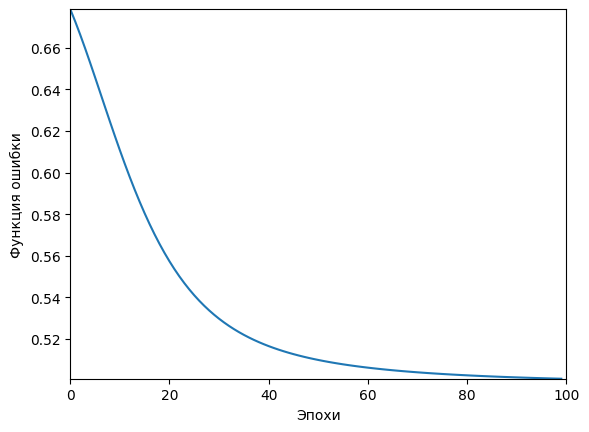

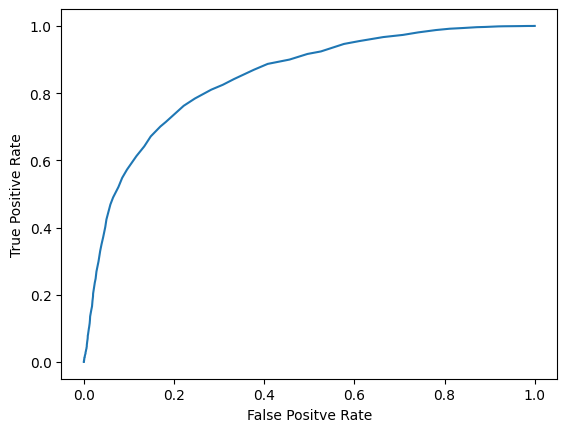

In [18]:
Main()